### Name: Sohan Rudra
### Roll No: 16MA20054

In [1]:
#library imports
import math
import time
from collections import namedtuple
from fractions import Fraction 
from copy import copy
import numpy as np
from numpy.linalg import inv
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%matplotlib notebook

In [2]:
#some boilerplate code
x = symbols('x')
y = symbols('y')
Equation = namedtuple('Equation',('alpha'))
Conditions = namedtuple('Conditions',('r','dx','dy','x0','xn','y0','yn','ub','uf'))

In [3]:
%%latex
\begin{align}
\frac{\partial u}{\partial t} = \nabla^2 u\\
u(x,y,0) = cos(\frac{\pi x}{2})cos(\frac{\pi y}{2})\\
u(-1,y,t) = 0,u(x,1,t) = 0,u(x,-1,t) = 0,u(1,y,t) = 0\\
\delta x = 0.25, \delta y = 0.25, r = \frac{1}{6}\\
\end{align}

<IPython.core.display.Latex object>

In [4]:
def initilize(cond):
    nx = int(np.ceil((cond.xn - cond.x0)/cond.dx))
    ny = int(np.ceil((cond.yn - cond.y0)/cond.dy))
    x_s = np.arange(cond.x0, cond.xn + cond.dx, cond.dx)
    y_s = np.arange(cond.y0, cond.yn + cond.dy, cond.dy)
    u = np.zeros((nx+1,ny+1))
    for i,xi in enumerate(x_s):
        for j,yj in enumerate(y_s):
            u[i][j] = cond.uf.subs([(x, xi), (y, yj)])
    return u

In [5]:
def Finite_Diff_Solver_ADI(cond, sols, i_x, j_y, calc='x'):
    n = 0
    if calc == 'x':
        n = int(np.ceil((cond.xn - cond.x0)/cond.dx))
    if calc == 'y':
        n = int(np.ceil((cond.yn - cond.y0)/cond.dy))
    a, b, c, d = np.zeros((n-2)), np.zeros((n-1)), np.zeros((n-2)), np.zeros((n-1))
    #A
    b[0] = -(1 + cond.r)
    c[0] = cond.r/2.0
    a[n-3] = cond.r/2.0
    b[n-2] = -(1 + cond.r)
    #d
    def calc_x():
        d[0] = -sols[j_y][1] -cond.r/2.0 * (sols[j_y+1][1] - 2.0*sols[j_y][1] + sols[j_y-1][1])- cond.r/2.0 * cond.ub
        d[n-2] = -sols[j_y][-2] -cond.r/2.0 * (sols[j_y+1][-2] - 2.0*sols[j_y][-2] + sols[j_y-1][-2]) - cond.r/2.0 * cond.ub
        for i, xi in enumerate(np.arange(cond.x0 + 2*cond.dx, cond.xn - cond.dx, cond.dx),\
                           start=1):
            a[i-1] = cond.r/2.0
            b[i] = -(1 + cond.r)
            c[i] = cond.r/2.0
            d[i] = -sols[j_y][i+1] -cond.r/2.0 * (sols[j_y+1][i+1] - 2*sols[j_y][i+1] + sols[j_y-1][i+1])
            
    def calc_y():
        d[0] = -sols[1][i_x] -cond.r/2.0 * (sols[1][i_x+1] - 2.0*sols[1][i_x] + sols[1][i_x-1])- cond.r/2.0 * cond.ub
        d[n-2] = -sols[-2][i_x] -cond.r/2.0 * (sols[-2][i_x+1] - 2.0*sols[-2][i_x] + sols[-2][i_x-1]) - cond.r/2.0 * cond.ub
        for j, yj in enumerate(np.arange(cond.y0 + 2*cond.dy, cond.yn - cond.dy, cond.dy),\
                           start=1):
            a[j-1] = cond.r/2.0
            b[j] = -(1 + cond.r)
            c[j] = cond.r/2.0
            d[j] = -sols[j+1][i_x] -cond.r/2.0 * (sols[j+1][i_x+1] - 2*sols[j+1][i_x] + sols[j+1][i_x-1])
    
    def tridiag(a, b, c, k1=-1, k2=0, k3=1):
        return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
    if calc=='x':
        calc_x()
    if calc=='y':
        calc_y()
    return (a,b,c,d)

In [6]:
def Thomas_Algorithm(coeff, cond, calc='x'):
    n = 0
    if calc == 'x':
        n = int(np.ceil((cond.xn - cond.x0)/cond.dx))
    if calc == 'y':
        n = int(np.ceil((cond.yn - cond.y0)/cond.dy))
    a, b, c, d = coeff
    c1 = np.zeros((n-2))
    d1 = np.zeros((n-1))
    c1[0] = c[0]/b[0]
    d1[0] = d[0]/b[0]
    for i in range(1,n-2):
        c1[i] = c[i]/(b[i]-a[i-1]*c1[i-1])
        d1[i] = (d[i] - a[i-1] * d1[i-1])/(b[i]-a[i-1]*c1[i-1])
    d1[n-2] = (d[n-2] - a[n-3] * d1[n-3])/(b[n-2] - a[n-3]*c1[n-3])
    def backsubstitution(c,d):
        y = np.zeros_like(d)
        y[-1] = d[-1]
        cache = y[-1]
        for i in reversed(range(d.shape[0]-1)):
            y[i] = d[i] - cache * c[i]
            cache = y[i]
        return y
    fin_y = backsubstitution(c1,d1)
    y = np.append(fin_y, cond.ub)
    y = np.append(cond.ub, y)
    return y

In [7]:
def PDE_ADI_Solver(eqn, cond, t_step):
    r = cond.r * cond.dx**2 / eqn.alpha
    nx = int(np.ceil((cond.xn - cond.x0)/cond.dx))
    ny = int(np.ceil((cond.yn - cond.y0)/cond.dy))
    U_sols = []
    u_init = initilize(cond)
    U_sols.append(u_init)
    u_i = u_init
    u_x = copy(u_i)
    u_y = copy(u_i)
    for k in range(t_step):
        t = u_i
        for i in range (1, nx):
            coeff = Finite_Diff_Solver_ADI(cond, u_i, 0, i, calc='x')
            u_x[i] = Thomas_Algorithm(coeff, cond, calc='x')

        for j in range (1, ny):
            coeff = Finite_Diff_Solver_ADI(cond, u_x, j, 0, calc='y')
            u_y[:,j] = Thomas_Algorithm(coeff, cond, calc='y')   
        u_i = copy(u_y)
        u_x = copy(u_y)
        U_sols.append(u_i) 
    return U_sols

In [8]:
cond = Conditions(Fraction(1,6),0.25,0.25,-1.0,1.0,-1.0,1.0,0.0,cos(np.pi*x/2.0)*cos(np.pi*y/2.0))
eqn = Equation(1)
u = PDE_ADI_Solver(eqn, cond, 100)

In [ ]:
i = np.arange(cond.x0, cond.xn + cond.dx, cond.dx)
j = np.arange(cond.y0, cond.yn + cond.dy, cond.dy)
X, Y = np.meshgrid(i, j)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0,1.0)
for i in range(len(u)):
    ax.clear()
    ax.plot_surface(X,Y,u[i],cmap=cm.coolwarm,linewidth=0, antialiased=True)
    fig.canvas.draw()
    time.sleep(0.5)
    
fig.clear()

In [ ]:
eqn = Equation(1)
cond = Conditions(Fraction(1,6),0.125,0.0,1.0,0.0,0.0,sin(np.pi*x))
y = PDE_Solver(eqn, cond, 10)
n = int(np.ceil((cond.xn - cond.x0)/cond.dx))
x_range = np.arange(0, n + 1)
fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(311)
ax.set_title("dx=0.125")
g = []
for i in range(len(y)):
    ax.plot(x_range, y[i])
    ax.scatter(x_range, y[i])
    g.append("t"+str(i))
ax.legend(tuple(g))
fig.show()

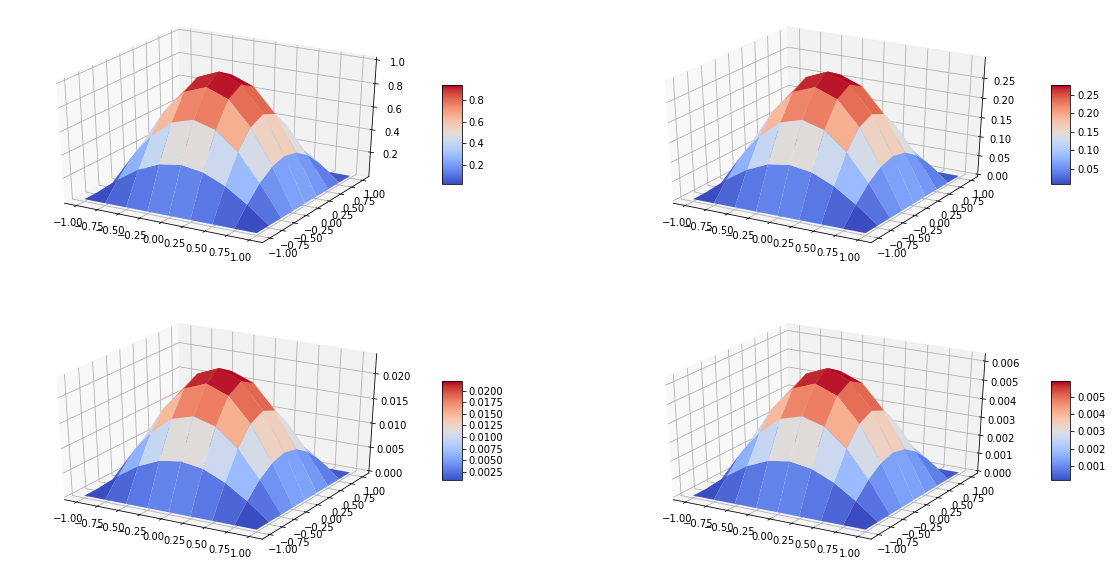

In [27]:
i = np.arange(cond.x0, cond.xn + cond.dx, cond.dx)
j = np.arange(cond.y0, cond.yn + cond.dy, cond.dy)
X, Y = np.meshgrid(i, j)
fig = plt.figure(figsize=(20,10))
fig.clear()
ax = fig.add_subplot(221, projection='3d')
surf = ax.plot_surface(X,Y,u[0],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.4, aspect=5)
ax = fig.add_subplot(222, projection='3d')
surf1 = ax.plot_surface(X,Y,u[24],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf1, shrink=0.4, aspect=5)
ax = fig.add_subplot(223, projection='3d')
surf1 = ax.plot_surface(X,Y,u[74],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf1, shrink=0.4, aspect=5)
ax = fig.add_subplot(224, projection='3d')
surf1 = ax.plot_surface(X,Y,u[-1],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf1, shrink=0.4, aspect=5)
plt.show()

In [34]:
cond = Conditions(Fraction(1,6),0.1,0.1,-1.0,1.0,-1.0,1.0,0.0,cos(np.pi*x/2.0)*cos(np.pi*y/2.0))
eqn = Equation(1)
u = PDE_ADI_Solver(eqn, cond, 100)

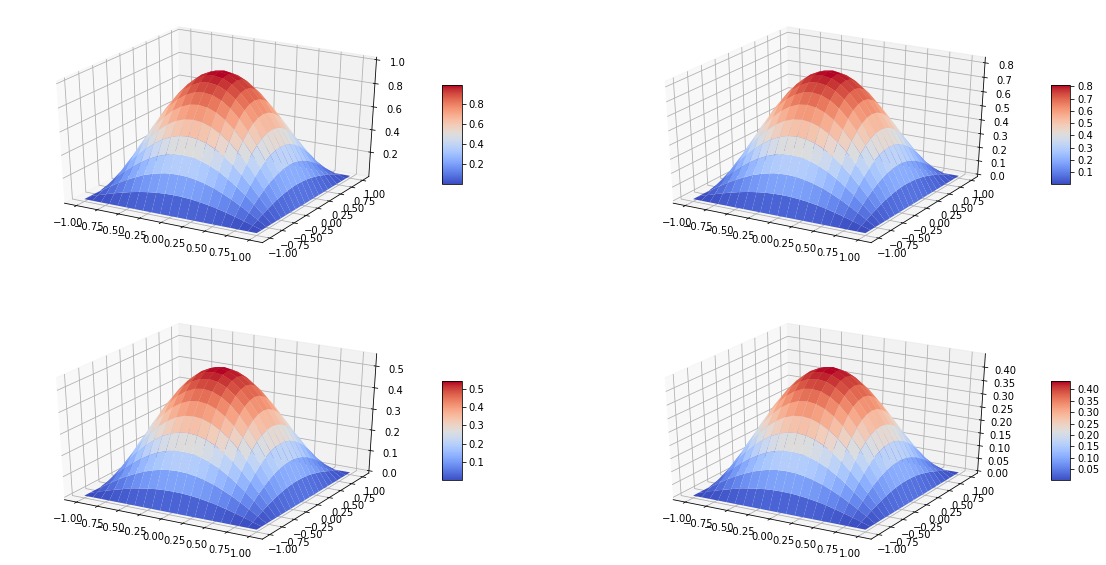

In [35]:
i = np.arange(cond.x0, cond.xn + cond.dx, cond.dx)
j = np.arange(cond.y0, cond.yn + cond.dy, cond.dy)
X, Y = np.meshgrid(i, j)
fig = plt.figure(figsize=(20,10))
fig.clear()
ax = fig.add_subplot(221, projection='3d')
surf = ax.plot_surface(X,Y,u[0],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.4, aspect=5)
ax = fig.add_subplot(222, projection='3d')
surf1 = ax.plot_surface(X,Y,u[24],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf1, shrink=0.4, aspect=5)
ax = fig.add_subplot(223, projection='3d')
surf1 = ax.plot_surface(X,Y,u[74],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf1, shrink=0.4, aspect=5)
ax = fig.add_subplot(224, projection='3d')
surf1 = ax.plot_surface(X,Y,u[-1],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf1, shrink=0.4, aspect=5)
plt.show()

In [31]:
cond = Conditions(Fraction(1,6),0.05,0.05,-1.0,1.0,-1.0,1.0,0.0,cos(np.pi*x/2.0)*cos(np.pi*y/2.0))
eqn = Equation(1)
u = PDE_ADI_Solver(eqn, cond, 100)

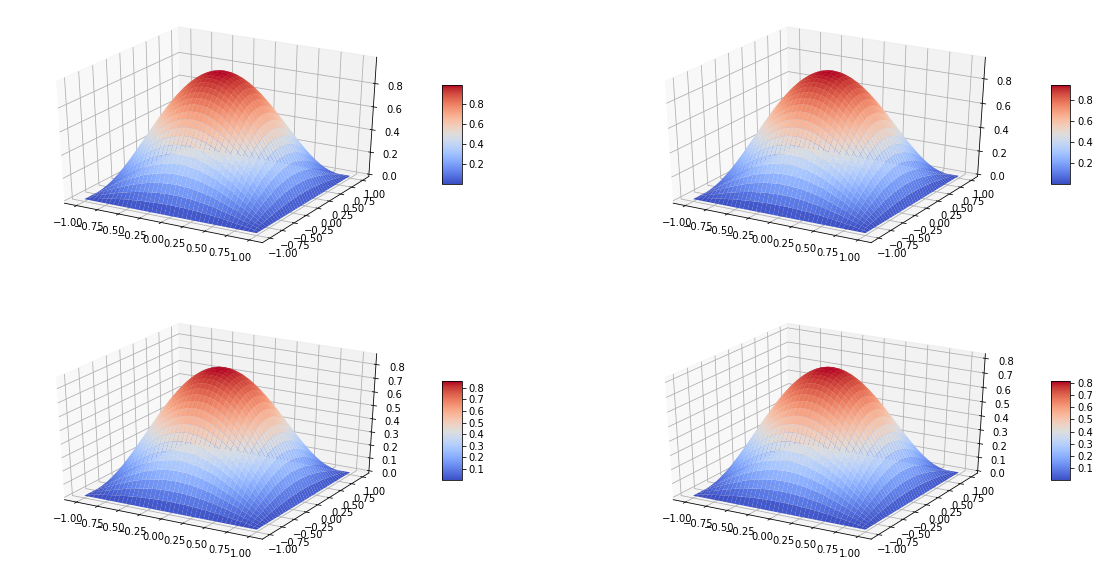

In [32]:
i = np.arange(cond.x0, cond.xn + cond.dx, cond.dx)
j = np.arange(cond.y0, cond.yn + cond.dy, cond.dy)
X, Y = np.meshgrid(i, j)
fig = plt.figure(figsize=(20,10))
fig.clear()
ax = fig.add_subplot(221, projection='3d')
surf = ax.plot_surface(X,Y,u[0],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.4, aspect=5)
ax = fig.add_subplot(222, projection='3d')
surf1 = ax.plot_surface(X,Y,u[24],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf1, shrink=0.4, aspect=5)
ax = fig.add_subplot(223, projection='3d')
surf1 = ax.plot_surface(X,Y,u[74],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf1, shrink=0.4, aspect=5)
ax = fig.add_subplot(224, projection='3d')
surf1 = ax.plot_surface(X,Y,u[-1],cmap=cm.coolwarm,linewidth=0, antialiased=True)
fig.colorbar(surf1, shrink=0.4, aspect=5)
plt.show()